In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Google Drive Paths
content_dir = "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content"
style_dir = "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/style"

In [ ]:
# Imports

import os
import random
import csv
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms
from torchvision.utils import save_image
from pathlib import Path

In [ ]:
# Conditional Instance Normalization Layer

class ConditionalInstanceNorm2d(nn.Module):

    def __init__(self, num_features, num_styles):
        super().__init__()
        self.num_features = num_features
        self.num_styles = num_styles

        self.gamma = nn.Embedding(num_styles, num_features)
        self.beta = nn.Embedding(num_styles, num_features)

        nn.init.ones_(self.gamma.weight)
        nn.init.zeros_(self.beta.weight)

        self.instance_norm = nn.InstanceNorm2d(num_features, affine=False)

    def forward(self, x, style_id):
        x_norm = self.instance_norm(x)
        gamma = self.gamma(style_id).view(-1, self.num_features, 1, 1)
        beta = self.beta(style_id).view(-1, self.num_features, 1, 1)
        return gamma * x_norm + beta

In [ ]:
# Residual Block

class ResidualBlock(nn.Module):
    def __init__(self, channels, num_styles):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.in1 = ConditionalInstanceNorm2d(channels, num_styles)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.in2 = ConditionalInstanceNorm2d(channels, num_styles)

    def forward(self, x, style_id):
        residual = x
        x = F.relu(self.in1(self.conv1(x), style_id))
        x = self.in2(self.conv2(x), style_id)
        return x + residual

In [ ]:
# Style Transfer Network

class StyleTransferNet(nn.Module):
    def __init__(self, num_styles):
        super().__init__()

        # Encoder
        self.conv1 = nn.Conv2d(3, 32, kernel_size=9, stride=1, padding=4, padding_mode='reflect')
        self.in1 = ConditionalInstanceNorm2d(32, num_styles)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, padding_mode='reflect')
        self.in2 = ConditionalInstanceNorm2d(64, num_styles)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, padding_mode='reflect')
        self.in3 = ConditionalInstanceNorm2d(128, num_styles)

        # Residual blocks
        self.res_blocks = nn.ModuleList([ResidualBlock(128, num_styles) for _ in range(5)])

        # Decoder (Upsampling + Convolution)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.deconv1 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.in4 = ConditionalInstanceNorm2d(64, num_styles)

        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.deconv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.in5 = ConditionalInstanceNorm2d(32, num_styles)

        # Output layer
        self.conv_out = nn.Conv2d(32, 3, kernel_size=9, stride=1, padding=4, padding_mode='reflect')

    def forward(self, x, style_id):
        x = F.relu(self.in1(self.conv1(x), style_id))
        x = F.relu(self.in2(self.conv2(x), style_id))
        x = F.relu(self.in3(self.conv3(x), style_id))

        for res_block in self.res_blocks:
            x = res_block(x, style_id)

        x = self.upsample1(x)
        x = F.relu(self.in4(self.deconv1(x), style_id))

        x = self.upsample2(x)
        x = F.relu(self.in5(self.deconv2(x), style_id))

        x = torch.sigmoid(self.conv_out(x))  # Final sigmoid activation
        return x

In [ ]:
# VGG Perceptual Loss

class VGGPerceptualLoss(nn.Module):

    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True).features
        self.slice1 = nn.Sequential(*list(vgg.children())[:4])    # relu1_2
        self.slice2 = nn.Sequential(*list(vgg.children())[4:9])   # relu2_2
        self.slice3 = nn.Sequential(*list(vgg.children())[9:16])  # relu3_3
        self.slice4 = nn.Sequential(*list(vgg.children())[16:23]) # relu4_3
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        h = self.slice1(x)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        return [h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3]

    def gram_matrix(self, x):
        B, C, H, W = x.size()
        features = x.view(B, C, H * W)
        G = torch.bmm(features, features.transpose(1, 2))
        return G / (C * H * W)

In [ ]:
# Content Image Dataset

class ContentImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                      if f.endswith(('.jpg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        try:
            img = Image.open(self.files[idx]).convert("RGB")
            if self.transform:
                img = self.transform(img)
            return img
        except Exception as e:
            print(f"Skipping image: {self.files[idx]} ({e})")
            return self.__getitem__((idx + 1) % len(self.files))

In [ ]:
# Style Images Loader

def load_style_images(style_folder, transform, device):
    style_imgs = []
    style_filenames = sorted([
        os.path.join(style_folder, f) for f in os.listdir(style_folder)
        if f.endswith(('.jpg', '.png'))
    ])
    for path in style_filenames:
        try:
            img = Image.open(path).convert('RGB')
            tensor = transform(img).unsqueeze(0).to(device)
            style_imgs.append(tensor)
        except Exception as e:
            print(f"Error loading {path}: {e}")
    return style_imgs

In [ ]:
# Sample Image Display During Training

def display_sample_images(pil_img, step):
    os.makedirs("outputs", exist_ok=True)
    output_path = f"outputs/sample_step_{step}.jpg"
    pil_img.save(output_path)
    display(pil_img)

In [ ]:
def normalise_batch(batch):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(batch.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(batch.device)
    return (batch - mean) / std

In [ ]:
def init_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.normal_(m.weight, mean=0.0, std=0.01)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

In [ ]:
def deprocess(tensor):

    tensor = tensor.clone().detach().cpu()
    tensor = tensor.squeeze(0)  # [1, 3, H, W] → [3, H, W]
    tensor = torch.clamp(tensor, 0, 1)  # ensure valid pixel range
    return transforms.ToPILImage()(tensor)

In [ ]:
from collections import namedtuple

# Define experiment configuration format
RunConfig = namedtuple("RunConfig", ["run_id", "cw", "sw", "optimizer"])

# Define experiments
experiments = [
    # Adam optimizer
    RunConfig("A", 1e4, 5e8, "adam"),
    RunConfig("B", 1e4, 1e9, "adam"),
    RunConfig("C", 1e4, 2e9, "adam"),
    RunConfig("D", 1e5, 5e8, "adam"),
    RunConfig("E", 1e5, 1e9, "adam"),
    RunConfig("F", 1e5, 2e9, "adam"),

    # RMSprop optimizer
    RunConfig("G", 1e4, 5e8, "rmsprop"),
    RunConfig("H", 1e4, 1e9, "rmsprop"),
    RunConfig("I", 1e4, 2e9, "rmsprop"),
    RunConfig("J", 1e5, 5e8, "rmsprop"),
    RunConfig("K", 1e5, 1e9, "rmsprop"),
    RunConfig("L", 1e5, 2e9, "rmsprop")
]

In [ ]:
def train_experiments(model, content_loader, style_imgs, style_ids,
                      device, run, num_iterations=40000, lr=1e-3,
                      checkpoint_base="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/checkpoints",
                      model_base="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM",
                      sample_output_base="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/hparams_outputs",
                      log_path="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/experiment_results.csv"):

    # Perceptual loss (VGG)
    vgg_loss = VGGPerceptualLoss().to(device)
    vgg_loss.eval()

    # Optimizer
    if run.optimizer.lower() == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
    elif run.optimizer.lower() == "rmsprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {run.optimizer}")

    # Normalize style images once
    normalized_styles = [normalise_batch(s.clone()) for s in style_imgs]

    # Checkpoint paths
    checkpoint_path = os.path.join(checkpoint_base, f"MSPM_checkpoint_hyp_{run.run_id}.pth")
    model_path = os.path.join(model_base, f"mspm_model_hyp_c{run.cw}_s{run.sw}_{run.optimizer}.pth")
    sample_output_dir = os.path.join(sample_output_base, f"run_{run.run_id}")
    os.makedirs(sample_output_dir, exist_ok=True)

    # Checkpoint Resume
    update_count = 0
    content_losses, style_losses, total_losses = [], [], []
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        if checkpoint.get('finished'):
            print(f"[{run.run_id}] Already completed. Skipping.")
            return
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        update_count = checkpoint['update_count']
        content_losses = checkpoint.get('content_losses', [])
        style_losses = checkpoint.get('style_losses', [])
        total_losses = checkpoint.get('total_losses', [])
        print(f"Resuming training from iteration {update_count}/{num_iterations}")
    else:
        print("Starting training from scratch")

    # Training mode
    model.train()
    style_num = len(style_ids)

    pbar = tqdm(total=num_iterations, initial=update_count, desc=f"Run {run.run_id}")
    step_idx = update_count

    while step_idx < num_iterations:
        for content in content_loader:
            if step_idx >= num_iterations:
                break

            content = content.to(device)
            B = content.size(0)

            # Cycle style index to guarantee even distribution
            current_style_id = style_ids[step_idx % style_num]
            sid = torch.tensor([current_style_id] * B).to(device)

            # Forward pass
            stylized = model(content, sid)

            # Normalize for VGG
            content_norm = normalise_batch(content.clone())
            stylized_norm = normalise_batch(stylized.clone())
            style_norm = normalized_styles[current_style_id]

            # Compute content features
            content_feats = vgg_loss(content_norm)
            stylized_feats = vgg_loss(stylized_norm)

            # Content loss
            content_loss = F.mse_loss(stylized_feats[1], content_feats[1])

            # Style loss
            style_loss = 0
            style_feat = vgg_loss(style_norm)
            for j in range(B):
                for f1, f2 in zip(stylized_feats, style_feat):
                    G_styled = vgg_loss.gram_matrix(f1[j].unsqueeze(0))
                    G_target = vgg_loss.gram_matrix(f2)
                    style_loss += F.mse_loss(G_styled, G_target)
            style_loss /= B

            # Total loss
            loss = run.cw * content_loss + run.sw * style_loss

            # Log losses
            content_losses.append(content_loss.item())
            style_losses.append(style_loss.item())
            total_losses.append(loss.item())

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update progress bar
            pbar.update(1)
            pbar.set_postfix({
                "Content Loss": round(content_loss.item(), 4),
                "Style Loss": round(style_loss.item(), 4)
            })

            # Save samples and checkpoint
            if step_idx % 500 == 0:
                tqdm.write(f"[{run.run_id}] Step {step_idx}/{num_iterations} | Content Loss: {content_loss.item():.4f} | Style Loss: {style_loss.item():.4f}")
                with torch.no_grad():
                    sample = stylized[0:1].clone().detach()
                    sample = deprocess(sample)
                    sample.save(os.path.join(sample_output_dir, f"step_{step_idx}.jpg"))

                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'update_count': step_idx,
                    'content_losses': content_losses,
                    'style_losses': style_losses,
                    'total_losses': total_losses,
                    'finished': False
                }, checkpoint_path)

            step_idx += 1

    pbar.close()

    # Save final model
    torch.save(model.state_dict(), model_path)
    print(f"[{run.run_id}] Model saved to {model_path}")

    # Mark checkpoint as finished
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'update_count': num_iterations,
        'content_losses': content_losses,
        'style_losses': style_losses,
        'total_losses': total_losses,
        'finished': True
    }, checkpoint_path)

    # Log to CSV
    if not os.path.exists(log_path) or os.stat(log_path).st_size == 0:
        with open(log_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["run_id", "cw", "sw", "optimizer", "final_content_loss", "final_style_loss", "final_total_loss", "model_path"])

    with open(log_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            run.run_id, run.cw, run.sw, run.optimizer,
            round(content_losses[-1], 4),
            round(style_losses[-1], 4),
            round(total_losses[-1], 4),
            model_path
        ])

In [ ]:
def run_experiments_pipeline():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Collect style paths from Drive folder
    style_paths = [
        os.path.join(style_dir, f)
        for f in os.listdir(style_dir)
        if f.lower().endswith(('.jpg', '.png'))
    ]

    # Hyperparameters
    num_styles = len(style_paths)
    learning_rate = 1e-3

    # Transforms
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor()
    ])

    # Dataset and Dataloader
    content_dataset = ContentImageDataset(content_dir, transform)
    content_loader = torch.utils.data.DataLoader(content_dataset, batch_size=16, num_workers=4, shuffle=True)

    # Load Style Images
    style_imgs = load_style_images(style_dir, transform, device)
    style_ids = list(range(num_styles))

    # Run All Experiments
    for run in experiments:
        print(f"\nStarting Experiment {run.run_id} | CW={run.cw}, SW={run.sw}, OPT={run.optimizer}")
        model = StyleTransferNet(num_styles=num_styles).to(device)
        init_weights(model)  # Reinitialize model
        train_experiments(model, content_loader, style_imgs, style_ids,
                          device=device, run=run, lr=learning_rate)


In [ ]:
run_experiments_pipeline()


Starting Experiment A | CW=10000.0, SW=500000000.0, OPT=adam


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 228MB/s]


[A] Already completed. Skipping.

Starting Experiment B | CW=10000.0, SW=1000000000.0, OPT=adam
[B] Already completed. Skipping.

Starting Experiment C | CW=10000.0, SW=2000000000.0, OPT=adam
[C] Already completed. Skipping.

Starting Experiment D | CW=100000.0, SW=500000000.0, OPT=adam
[D] Already completed. Skipping.

Starting Experiment E | CW=100000.0, SW=1000000000.0, OPT=adam
[E] Already completed. Skipping.

Starting Experiment F | CW=100000.0, SW=2000000000.0, OPT=adam
[F] Already completed. Skipping.

Starting Experiment G | CW=10000.0, SW=500000000.0, OPT=rmsprop
[G] Already completed. Skipping.

Starting Experiment H | CW=10000.0, SW=1000000000.0, OPT=rmsprop
[H] Already completed. Skipping.

Starting Experiment I | CW=10000.0, SW=2000000000.0, OPT=rmsprop
[I] Already completed. Skipping.

Starting Experiment J | CW=100000.0, SW=500000000.0, OPT=rmsprop
[J] Already completed. Skipping.

Starting Experiment K | CW=100000.0, SW=1000000000.0, OPT=rmsprop
[K] Already completed. 

Run L:  71%|███████▏  | 28501/40000 [00:06<19:23:36,  6.07s/it, Content Loss=2.11, Style Loss=0.0001]

[L] Step 28500/40000 | Content Loss: 2.1099 | Style Loss: 0.0001


Run L:  71%|███████▏  | 28508/40000 [00:11<2:42:04,  1.18it/s, Content Loss=3.57, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144860.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144860.jpg')


Run L:  71%|███████▏  | 28582/40000 [01:43<3:02:55,  1.04it/s, Content Loss=4.28, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070027.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070027.jpg')


Run L:  72%|███████▏  | 28625/40000 [02:30<2:28:13,  1.28it/s, Content Loss=0.984, Style Loss=0]   

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170822.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170822.jpg')


Run L:  72%|███████▏  | 28678/40000 [03:37<2:17:33,  1.37it/s, Content Loss=3.25, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170954.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170954.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170822.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170822.jpg')


Run L:  72%|███████▏  | 28684/40000 [03:46<3:46:02,  1.20s/it, Content Loss=3.62, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070052.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070052.jpg')


Run L:  72%|███████▏  | 28717/40000 [04:22<2:57:16,  1.06it/s, Content Loss=1.82, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170863.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170863.jpg')


Run L:  72%|███████▏  | 28743/40000 [04:57<3:51:37,  1.23s/it, Content Loss=3.03, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144962.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144962.jpg')


Run L:  72%|███████▏  | 28787/40000 [05:45<2:08:59,  1.45it/s, Content Loss=3.93, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170905.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170905.jpg')


Run L:  72%|███████▏  | 28836/40000 [06:51<2:41:17,  1.15it/s, Content Loss=1.95, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070126.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070126.jpg')


Run L:  72%|███████▏  | 28848/40000 [07:04<2:37:39,  1.18it/s, Content Loss=3.05, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145045.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145045.jpg')


Run L:  72%|███████▏  | 28876/40000 [07:54<3:30:52,  1.14s/it, Content Loss=1.78, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070078.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070078.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070105.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070105.jpg')


Run L:  72%|███████▏  | 28948/40000 [09:16<2:07:32,  1.44it/s, Content Loss=2.94, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070015.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070015.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070028.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070028.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070108.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070108.jpg')


Run L:  73%|███████▎  | 29002/40000 [10:24<4:56:02,  1.62s/it, Content Loss=1.97, Style Loss=0]

[L] Step 29000/40000 | Content Loss: 1.9696 | Style Loss: 0.0000


Run L:  73%|███████▎  | 29024/40000 [10:48<2:19:48,  1.31it/s, Content Loss=3.82, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040324.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040324.jpg')


Run L:  73%|███████▎  | 29040/40000 [11:09<2:20:34,  1.30it/s, Content Loss=1.08, Style Loss=0]     

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144948.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144948.jpg')


Run L:  73%|███████▎  | 29113/40000 [12:42<2:50:04,  1.07it/s, Content Loss=3.35, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070028.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070028.jpg')


Run L:  73%|███████▎  | 29147/40000 [13:36<2:54:02,  1.04it/s, Content Loss=3.47, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040302.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040302.jpg')


Run L:  73%|███████▎  | 29202/40000 [14:47<2:04:27,  1.45it/s, Content Loss=3.81, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000091027.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000091027.jpg')


Run L:  73%|███████▎  | 29218/40000 [15:06<2:29:54,  1.20it/s, Content Loss=3.08, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145002.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145002.jpg')


Run L:  73%|███████▎  | 29266/40000 [16:03<2:06:04,  1.42it/s, Content Loss=1.89, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040294.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040294.jpg')


Run L:  73%|███████▎  | 29350/40000 [17:44<3:12:43,  1.09s/it, Content Loss=0.839, Style Loss=0]   

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394300.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394300.jpg')


Run L:  73%|███████▎  | 29360/40000 [17:56<2:14:48,  1.32it/s, Content Loss=0.931, Style Loss=0]    

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040276.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040276.jpg')


Run L:  74%|███████▎  | 29422/40000 [19:13<2:25:41,  1.21it/s, Content Loss=4.1, Style Loss=0.0001] 

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145050.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145050.jpg')


Run L:  74%|███████▍  | 29502/40000 [20:45<1:59:18,  1.47it/s, Content Loss=1.72, Style Loss=0.0001]

[L] Step 29500/40000 | Content Loss: 1.7183 | Style Loss: 0.0001


Run L:  74%|███████▍  | 29687/40000 [24:11<2:41:37,  1.06it/s, Content Loss=3.55, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170958.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170958.jpg')


Run L:  74%|███████▍  | 29704/40000 [24:29<1:50:57,  1.55it/s, Content Loss=3.64, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145038.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145038.jpg')


Run L:  74%|███████▍  | 29741/40000 [25:10<1:43:05,  1.66it/s, Content Loss=1.92, Style Loss=0]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040281.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040281.jpg')


Run L:  74%|███████▍  | 29745/40000 [25:14<1:50:21,  1.55it/s, Content Loss=0.929, Style Loss=0]    

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145054.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145054.jpg')


Run L:  74%|███████▍  | 29749/40000 [25:20<2:27:45,  1.16it/s, Content Loss=3.07, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040279.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040279.jpg')


Run L:  75%|███████▍  | 29805/40000 [26:28<1:56:21,  1.46it/s, Content Loss=1.05, Style Loss=0]    

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170923.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170923.jpg')


Run L:  75%|███████▍  | 29821/40000 [26:45<1:42:44,  1.65it/s, Content Loss=1.92, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170868.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170868.jpg')


Run L:  75%|███████▍  | 29825/40000 [26:49<1:38:48,  1.72it/s, Content Loss=1.13, Style Loss=0]     

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040326.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040326.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040294.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040294.jpg')


Run L:  75%|███████▍  | 29830/40000 [26:56<3:05:35,  1.09s/it, Content Loss=0.901, Style Loss=0]   

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144917.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144917.jpg')


Run L:  75%|███████▍  | 29886/40000 [28:06<1:48:10,  1.56it/s, Content Loss=1.94, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394308.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394308.jpg')


Run L:  75%|███████▌  | 30002/40000 [30:25<4:18:42,  1.55s/it, Content Loss=1.84, Style Loss=0.0001]

[L] Step 30000/40000 | Content Loss: 1.8415 | Style Loss: 0.0001


Run L:  75%|███████▌  | 30028/40000 [30:51<1:46:39,  1.56it/s, Content Loss=3.24, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394299.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394299.jpg')


Run L:  75%|███████▌  | 30053/40000 [31:20<3:56:45,  1.43s/it, Content Loss=2.68, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170920.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170920.jpg')


Run L:  75%|███████▌  | 30060/40000 [31:25<1:55:47,  1.43it/s, Content Loss=0.979, Style Loss=0]    

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070022.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070022.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070068.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070068.jpg')


Run L:  75%|███████▌  | 30084/40000 [31:52<1:50:48,  1.49it/s, Content Loss=4.03, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394278.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394278.jpg')


Run L:  75%|███████▌  | 30100/40000 [32:10<1:51:46,  1.48it/s, Content Loss=1.22, Style Loss=0]     

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170944.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170944.jpg')


Run L:  75%|███████▌  | 30176/40000 [33:39<1:53:22,  1.44it/s, Content Loss=1.82, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394356.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394356.jpg')


Run L:  76%|███████▌  | 30221/40000 [34:32<4:34:15,  1.68s/it, Content Loss=0.92, Style Loss=0]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144858 (1).jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144858 (1).jpg')


Run L:  76%|███████▌  | 30224/40000 [34:32<1:51:03,  1.47it/s, Content Loss=3.25, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394282.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394282.jpg')


Run L:  76%|███████▌  | 30240/40000 [34:50<1:41:50,  1.60it/s, Content Loss=0.813, Style Loss=0]    

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000069984.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000069984.jpg')


Run L:  76%|███████▌  | 30492/40000 [40:15<1:40:26,  1.58it/s, Content Loss=3.91, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144956.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144956.jpg')


Run L:  76%|███████▋  | 30501/40000 [40:27<4:22:29,  1.66s/it, Content Loss=1.85, Style Loss=0.0001]

[L] Step 30500/40000 | Content Loss: 1.8515 | Style Loss: 0.0001


Run L:  76%|███████▋  | 30513/40000 [40:39<2:29:38,  1.06it/s, Content Loss=2.66, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170942.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170942.jpg')


Run L:  76%|███████▋  | 30533/40000 [41:05<2:52:04,  1.09s/it, Content Loss=3.05, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394254.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394254.jpg')


Run L:  76%|███████▋  | 30545/40000 [41:21<1:54:02,  1.38it/s, Content Loss=0.943, Style Loss=0]    

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040369.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040369.jpg')


Run L:  76%|███████▋  | 30569/40000 [41:54<2:53:00,  1.10s/it, Content Loss=3.52, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070068.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070068.jpg')


Run L:  76%|███████▋  | 30593/40000 [42:21<1:56:30,  1.35it/s, Content Loss=3.09, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170851.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170851.jpg')


Run L:  76%|███████▋  | 30597/40000 [42:27<2:24:44,  1.08it/s, Content Loss=3.99, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170880.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170880.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170945.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170945.jpg')


Run L:  77%|███████▋  | 30605/40000 [42:38<2:27:34,  1.06it/s, Content Loss=0.816, Style Loss=0]    

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170839.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170839.jpg')


Run L:  77%|███████▋  | 30617/40000 [42:52<1:49:11,  1.43it/s, Content Loss=3.32, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040336.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040336.jpg')


Run L:  77%|███████▋  | 30669/40000 [44:01<2:34:18,  1.01it/s, Content Loss=3.27, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070105.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070105.jpg')


Run L:  77%|███████▋  | 30709/40000 [44:47<1:48:51,  1.42it/s, Content Loss=3.49, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070030.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070030.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070110.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070110.jpg')


Run L:  77%|███████▋  | 30721/40000 [45:01<1:44:49,  1.48it/s, Content Loss=2.18, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394333.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394333.jpg')


Run L:  77%|███████▋  | 30753/40000 [45:40<3:56:26,  1.53s/it, Content Loss=3.22, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394358.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394358.jpg')


Run L:  77%|███████▋  | 30836/40000 [47:14<2:28:06,  1.03it/s, Content Loss=1.85, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170875.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170875.jpg')


Run L:  77%|███████▋  | 30894/40000 [48:23<4:44:53,  1.88s/it, Content Loss=3.79, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170945.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170945.jpg')


Run L:  78%|███████▊  | 31001/40000 [50:30<2:38:03,  1.05s/it, Content Loss=1.88, Style Loss=0.0001]

[L] Step 31000/40000 | Content Loss: 1.8752 | Style Loss: 0.0001


Run L:  78%|███████▊  | 31054/40000 [51:29<2:03:13,  1.21it/s, Content Loss=3.09, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070021.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070021.jpg')


Run L:  78%|███████▊  | 31185/40000 [54:28<1:57:08,  1.25it/s, Content Loss=0.79, Style Loss=0]     

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040266.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040266.jpg')


Run L:  78%|███████▊  | 31193/40000 [54:39<1:46:15,  1.38it/s, Content Loss=3, Style Loss=0.0001]   

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070038.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070038.jpg')


Run L:  78%|███████▊  | 31236/40000 [55:43<2:13:05,  1.10it/s, Content Loss=1.76, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040333.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040333.jpg')


Run L:  79%|███████▊  | 31424/40000 [59:51<1:36:24,  1.48it/s, Content Loss=3.59, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144864 (1).jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144864 (1).jpg')


Run L:  79%|███████▊  | 31453/40000 [1:00:26<2:05:47,  1.13it/s, Content Loss=3.41, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144899.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144899.jpg')


Run L:  79%|███████▉  | 31501/40000 [1:01:25<2:17:25,  1.03it/s, Content Loss=1.88, Style Loss=0.0001]

[L] Step 31500/40000 | Content Loss: 1.8760 | Style Loss: 0.0001


Run L:  79%|███████▉  | 31505/40000 [1:01:30<1:58:50,  1.19it/s, Content Loss=1.22, Style Loss=0]     

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144923.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144923.jpg')


Run L:  79%|███████▉  | 31529/40000 [1:02:01<1:30:46,  1.56it/s, Content Loss=3.74, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394314.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394314.jpg')


Run L:  79%|███████▉  | 31575/40000 [1:03:05<1:36:31,  1.45it/s, Content Loss=1.01, Style Loss=0]     

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040254.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040254.jpg')


Run L:  79%|███████▉  | 31621/40000 [1:04:01<1:37:54,  1.43it/s, Content Loss=1.92, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144947.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144947.jpg')


Run L:  79%|███████▉  | 31712/40000 [1:04:19<21:49,  6.33it/s, Content Loss=3.6, Style Loss=0.0001] 

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170851.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170851.jpg')


Run L:  79%|███████▉  | 31721/40000 [1:04:20<21:47,  6.33it/s, Content Loss=1.13, Style Loss=0]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170868.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170868.jpg')


Run L:  80%|███████▉  | 31924/40000 [1:04:52<21:09,  6.36it/s, Content Loss=3.25, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170923.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170923.jpg')


Run L:  80%|███████▉  | 31962/40000 [1:04:58<21:05,  6.35it/s, Content Loss=1.68, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394356.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394356.jpg')


Run L:  80%|████████  | 32001/40000 [1:05:04<21:15,  6.27it/s, Content Loss=1.88, Style Loss=0.0001]

[L] Step 32000/40000 | Content Loss: 1.8836 | Style Loss: 0.0001


Run L:  81%|████████  | 32281/40000 [1:05:49<20:18,  6.33it/s, Content Loss=1.85, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040333.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040333.jpg')


Run L:  81%|████████  | 32305/40000 [1:05:53<20:26,  6.28it/s, Content Loss=3.8, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040336.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040336.jpg')


Run L:  81%|████████  | 32411/40000 [1:06:09<20:18,  6.23it/s, Content Loss=1.11, Style Loss=0]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144858 (1).jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144858 (1).jpg')


Run L:  81%|████████  | 32482/40000 [1:06:21<19:44,  6.34it/s, Content Loss=3.86, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394308.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394308.jpg')


Run L:  81%|████████▏ | 32502/40000 [1:06:24<23:48,  5.25it/s, Content Loss=1.76, Style Loss=0.0001]

[L] Step 32500/40000 | Content Loss: 1.7591 | Style Loss: 0.0001


Run L:  81%|████████▏ | 32561/40000 [1:06:33<19:33,  6.34it/s, Content Loss=1.87, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145054.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145054.jpg')


Run L:  81%|████████▏ | 32593/40000 [1:06:38<19:36,  6.30it/s, Content Loss=3.16, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145038.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145038.jpg')


Run L:  82%|████████▏ | 32628/40000 [1:06:44<19:18,  6.36it/s, Content Loss=3.21, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170945.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170945.jpg')


Run L:  82%|████████▏ | 32648/40000 [1:06:47<19:21,  6.33it/s, Content Loss=3.12, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000091027.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000091027.jpg')


Run L:  82%|████████▏ | 32650/40000 [1:06:47<19:23,  6.32it/s, Content Loss=0.925, Style Loss=0]    

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144956.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144956.jpg')


Run L:  82%|████████▏ | 32655/40000 [1:06:48<19:32,  6.26it/s, Content Loss=0.898, Style Loss=0]    

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144864 (1).jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144864 (1).jpg')


Run L:  82%|████████▏ | 32733/40000 [1:07:00<19:13,  6.30it/s, Content Loss=3.06, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394282.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394282.jpg')


Run L:  82%|████████▏ | 32814/40000 [1:07:13<18:58,  6.31it/s, Content Loss=3.59, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394254.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394254.jpg')


Run L:  82%|████████▏ | 32825/40000 [1:07:15<18:57,  6.31it/s, Content Loss=3.46, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070052.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070052.jpg')


Run L:  82%|████████▏ | 32877/40000 [1:07:23<18:43,  6.34it/s, Content Loss=3.91, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145002.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145002.jpg')


Run L:  82%|████████▏ | 32915/40000 [1:07:29<18:38,  6.33it/s, Content Loss=0.806, Style Loss=0]   

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070126.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070126.jpg')


Run L:  82%|████████▏ | 32918/40000 [1:07:30<18:59,  6.22it/s, Content Loss=2.76, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070022.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070022.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070068.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070068.jpg')


Run L:  83%|████████▎ | 33002/40000 [1:07:43<22:22,  5.21it/s, Content Loss=1.95, Style Loss=0.0001]

[L] Step 33000/40000 | Content Loss: 1.9476 | Style Loss: 0.0001


Run L:  83%|████████▎ | 33036/40000 [1:07:48<18:37,  6.23it/s, Content Loss=1.82, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070105.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070105.jpg')


Run L:  83%|████████▎ | 33085/40000 [1:07:56<18:12,  6.33it/s, Content Loss=3.36, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040302.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040302.jpg')


Run L:  83%|████████▎ | 33158/40000 [1:08:08<18:01,  6.33it/s, Content Loss=3.64, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070015.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070015.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070028.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070028.jpg')


Run L:  83%|████████▎ | 33158/40000 [1:08:08<18:01,  6.33it/s, Content Loss=3.12, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170880.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170880.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170945.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170945.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040326.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040326.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040294.jpg (cannot identify image file '/content/

Run L:  83%|████████▎ | 33187/40000 [1:08:12<17:58,  6.32it/s, Content Loss=3.4, Style Loss=0.0001] 

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070110.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070110.jpg')


Run L:  83%|████████▎ | 33242/40000 [1:08:21<17:47,  6.33it/s, Content Loss=1.93, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394299.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394299.jpg')


Run L:  83%|████████▎ | 33297/40000 [1:08:30<17:41,  6.31it/s, Content Loss=3.92, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070068.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070068.jpg')


Run L:  83%|████████▎ | 33327/40000 [1:08:34<17:33,  6.34it/s, Content Loss=3.64, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144860.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144860.jpg')


Run L:  83%|████████▎ | 33328/40000 [1:08:35<17:33,  6.33it/s, Content Loss=3.06, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070030.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070030.jpg')


Run L:  83%|████████▎ | 33340/40000 [1:08:37<17:27,  6.36it/s, Content Loss=0.97, Style Loss=0]     

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144923.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144923.jpg')


Run L:  83%|████████▎ | 33367/40000 [1:08:41<17:39,  6.26it/s, Content Loss=3.55, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170954.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170954.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170822.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170822.jpg')


Run L:  84%|████████▎ | 33409/40000 [1:08:47<17:28,  6.28it/s, Content Loss=3.57, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040281.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040281.jpg')


Run L:  84%|████████▎ | 33412/40000 [1:08:48<17:34,  6.25it/s, Content Loss=3.83, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394314.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394314.jpg')


Run L:  84%|████████▎ | 33473/40000 [1:08:58<17:26,  6.24it/s, Content Loss=4.06, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394300.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394300.jpg')


Run L:  84%|████████▍ | 33502/40000 [1:09:02<20:29,  5.29it/s, Content Loss=1.79, Style Loss=0.0001]

[L] Step 33500/40000 | Content Loss: 1.7876 | Style Loss: 0.0001


Run L:  84%|████████▍ | 33502/40000 [1:09:02<20:29,  5.29it/s, Content Loss=3.27, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040279.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040279.jpg')


Run L:  84%|████████▍ | 33513/40000 [1:09:04<17:06,  6.32it/s, Content Loss=3.04, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144947.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144947.jpg')


Run L:  84%|████████▍ | 33517/40000 [1:09:05<17:12,  6.28it/s, Content Loss=3.5, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070078.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070078.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070105.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070105.jpg')


Run L:  84%|████████▍ | 33535/40000 [1:09:08<17:06,  6.30it/s, Content Loss=0.991, Style Loss=0]    

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000069984.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000069984.jpg')


Run L:  84%|████████▍ | 33641/40000 [1:09:24<16:43,  6.34it/s, Content Loss=1.84, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170875.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170875.jpg')


Run L:  84%|████████▍ | 33749/40000 [1:09:41<16:36,  6.27it/s, Content Loss=3.23, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070027.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070027.jpg')


Run L:  84%|████████▍ | 33769/40000 [1:09:45<16:25,  6.32it/s, Content Loss=3.44, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040276.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040276.jpg')


Run L:  84%|████████▍ | 33783/40000 [1:09:47<16:21,  6.33it/s, Content Loss=3.59, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170920.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170920.jpg')


Run L:  85%|████████▍ | 33805/40000 [1:09:50<16:31,  6.25it/s, Content Loss=1.02, Style Loss=0]     

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070108.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070108.jpg')


Run L:  85%|████████▍ | 33806/40000 [1:09:50<16:14,  6.36it/s, Content Loss=1.92, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145045.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145045.jpg')


Run L:  85%|████████▍ | 33809/40000 [1:09:51<16:21,  6.31it/s, Content Loss=3.51, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040294.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040294.jpg')


Run L:  85%|████████▍ | 33825/40000 [1:09:53<16:11,  6.36it/s, Content Loss=3.42, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144899.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144899.jpg')


Run L:  85%|████████▍ | 33837/40000 [1:09:55<16:15,  6.32it/s, Content Loss=3.58, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170942.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170942.jpg')


Run L:  85%|████████▍ | 33852/40000 [1:09:58<16:19,  6.28it/s, Content Loss=4.04, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144917.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144917.jpg')


Run L:  85%|████████▍ | 33872/40000 [1:10:01<16:08,  6.33it/s, Content Loss=4.3, Style Loss=0.0001] 

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170822.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170822.jpg')


Run L:  85%|████████▍ | 33970/40000 [1:10:16<15:51,  6.34it/s, Content Loss=0.836, Style Loss=0]    

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070028.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070028.jpg')


Run L:  85%|████████▌ | 34002/40000 [1:10:21<19:07,  5.23it/s, Content Loss=2.01, Style Loss=0.0001]

[L] Step 34000/40000 | Content Loss: 2.0056 | Style Loss: 0.0001


Run L:  85%|████████▌ | 34058/40000 [1:10:30<15:39,  6.32it/s, Content Loss=3, Style Loss=0.0001]   

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040369.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040369.jpg')


Run L:  85%|████████▌ | 34068/40000 [1:10:32<15:48,  6.26it/s, Content Loss=3.03, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394333.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394333.jpg')


Run L:  85%|████████▌ | 34133/40000 [1:10:42<15:20,  6.37it/s, Content Loss=3.36, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170958.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170958.jpg')


Run L:  86%|████████▌ | 34208/40000 [1:10:54<15:18,  6.31it/s, Content Loss=2.9, Style Loss=0.0001] 

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040254.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040254.jpg')


Run L:  86%|████████▌ | 34209/40000 [1:10:54<15:15,  6.33it/s, Content Loss=3.74, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040266.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040266.jpg')


Run L:  86%|████████▌ | 34248/40000 [1:11:00<15:08,  6.33it/s, Content Loss=2.93, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170863.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170863.jpg')


Run L:  86%|████████▌ | 34280/40000 [1:11:05<15:03,  6.33it/s, Content Loss=3.23, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170839.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170839.jpg')


Run L:  86%|████████▌ | 34316/40000 [1:11:11<14:57,  6.33it/s, Content Loss=0.933, Style Loss=0]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144962.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144962.jpg')


Run L:  86%|████████▌ | 34344/40000 [1:11:16<14:53,  6.33it/s, Content Loss=3.27, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170944.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170944.jpg')


Run L:  86%|████████▌ | 34378/40000 [1:11:21<14:48,  6.33it/s, Content Loss=3.22, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144948.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144948.jpg')


Run L:  86%|████████▌ | 34395/40000 [1:11:24<14:42,  6.35it/s, Content Loss=0.993, Style Loss=0]    

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394358.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394358.jpg')


Run L:  86%|████████▌ | 34459/40000 [1:11:34<14:36,  6.32it/s, Content Loss=3.34, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040324.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040324.jpg')


Run L:  86%|████████▋ | 34502/40000 [1:11:41<17:24,  5.26it/s, Content Loss=1.98, Style Loss=0.0001]

[L] Step 34500/40000 | Content Loss: 1.9804 | Style Loss: 0.0001


Run L:  86%|████████▋ | 34504/40000 [1:11:41<15:51,  5.77it/s, Content Loss=3.71, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394278.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394278.jpg')


Run L:  86%|████████▋ | 34517/40000 [1:11:43<14:28,  6.31it/s, Content Loss=3.36, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070021.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070021.jpg')


Run L:  86%|████████▋ | 34570/40000 [1:11:52<14:20,  6.31it/s, Content Loss=0.966, Style Loss=0]    

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070038.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070038.jpg')


Run L:  87%|████████▋ | 34621/40000 [1:12:00<14:22,  6.24it/s, Content Loss=2, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170905.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170905.jpg')


Run L:  87%|████████▋ | 34703/40000 [1:12:13<13:56,  6.33it/s, Content Loss=3.86, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145050.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145050.jpg')


Run L:  87%|████████▋ | 34843/40000 [1:12:35<13:35,  6.32it/s, Content Loss=3.09, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145050.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145050.jpg')


Run L:  87%|████████▋ | 34971/40000 [1:12:55<13:24,  6.25it/s, Content Loss=1.92, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170851.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170851.jpg')


Run L:  87%|████████▋ | 34988/40000 [1:12:58<13:14,  6.31it/s, Content Loss=3.03, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144917.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144917.jpg')


Run L:  88%|████████▊ | 35001/40000 [1:13:00<13:18,  6.26it/s, Content Loss=1.89, Style Loss=0]

[L] Step 35000/40000 | Content Loss: 1.8884 | Style Loss: 0.0000


Run L:  88%|████████▊ | 35056/40000 [1:13:09<13:01,  6.33it/s, Content Loss=2.08, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070028.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070028.jpg')


Run L:  88%|████████▊ | 35058/40000 [1:13:09<13:01,  6.32it/s, Content Loss=3.54, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070126.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070126.jpg')


Run L:  88%|████████▊ | 35065/40000 [1:13:10<12:56,  6.36it/s, Content Loss=0.835, Style Loss=0]    

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170923.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170923.jpg')


Run L:  88%|████████▊ | 35105/40000 [1:13:16<12:57,  6.30it/s, Content Loss=1.18, Style Loss=0]     

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394358.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394358.jpg')


Run L:  88%|████████▊ | 35113/40000 [1:13:18<12:58,  6.28it/s, Content Loss=3.97, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040276.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040276.jpg')


Run L:  88%|████████▊ | 35137/40000 [1:13:22<12:46,  6.35it/s, Content Loss=3.27, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170905.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170905.jpg')


Run L:  88%|████████▊ | 35164/40000 [1:13:26<12:45,  6.32it/s, Content Loss=3.57, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394333.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394333.jpg')


Run L:  88%|████████▊ | 35183/40000 [1:13:29<12:38,  6.35it/s, Content Loss=4.13, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070030.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070030.jpg')


Run L:  88%|████████▊ | 35209/40000 [1:13:33<12:34,  6.35it/s, Content Loss=3.5, Style Loss=0.0001] 

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145038.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145038.jpg')


Run L:  88%|████████▊ | 35276/40000 [1:13:43<12:26,  6.33it/s, Content Loss=0.884, Style Loss=0]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070068.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070068.jpg')


Run L:  88%|████████▊ | 35311/40000 [1:13:49<12:24,  6.30it/s, Content Loss=1.79, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144899.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144899.jpg')


Run L:  88%|████████▊ | 35316/40000 [1:13:50<12:17,  6.35it/s, Content Loss=1.87, Style Loss=0]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145002.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145002.jpg')


Run L:  88%|████████▊ | 35334/40000 [1:13:53<12:22,  6.28it/s, Content Loss=3.43, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070052.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070052.jpg')


Run L:  88%|████████▊ | 35338/40000 [1:13:53<12:18,  6.31it/s, Content Loss=3.11, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144858 (1).jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144858 (1).jpg')


Run L:  88%|████████▊ | 35341/40000 [1:13:54<12:13,  6.36it/s, Content Loss=2.01, Style Loss=0] 

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040326.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040326.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040294.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040294.jpg')


Run L:  89%|████████▊ | 35491/40000 [1:14:18<11:55,  6.30it/s, Content Loss=2.03, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394314.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394314.jpg')


Run L:  89%|████████▉ | 35502/40000 [1:14:19<14:07,  5.31it/s, Content Loss=1.9, Style Loss=0.0001]

[L] Step 35500/40000 | Content Loss: 1.9026 | Style Loss: 0.0001


Run L:  89%|████████▉ | 35535/40000 [1:14:25<11:43,  6.34it/s, Content Loss=0.8, Style Loss=0]      

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000069984.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000069984.jpg')


Run L:  89%|████████▉ | 35647/40000 [1:14:42<11:32,  6.29it/s, Content Loss=2.98, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070038.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070038.jpg')


Run L:  89%|████████▉ | 35655/40000 [1:14:44<11:25,  6.34it/s, Content Loss=1.11, Style Loss=0]     

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170954.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170954.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170822.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170822.jpg')


Run L:  89%|████████▉ | 35662/40000 [1:14:45<11:28,  6.30it/s, Content Loss=1.88, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070108.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070108.jpg')


Run L:  89%|████████▉ | 35671/40000 [1:14:46<11:24,  6.32it/s, Content Loss=1.88, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394308.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394308.jpg')


Run L:  89%|████████▉ | 35673/40000 [1:14:46<11:21,  6.35it/s, Content Loss=3.01, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394356.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394356.jpg')


Run L:  89%|████████▉ | 35720/40000 [1:14:54<11:18,  6.31it/s, Content Loss=1.04, Style Loss=0]     

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170945.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170945.jpg')


Run L:  89%|████████▉ | 35748/40000 [1:14:58<11:09,  6.35it/s, Content Loss=2.94, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394254.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394254.jpg')


Run L:  90%|████████▉ | 35837/40000 [1:15:12<11:01,  6.29it/s, Content Loss=3.56, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170875.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170875.jpg')


Run L:  90%|████████▉ | 35878/40000 [1:15:19<11:03,  6.21it/s, Content Loss=3.1, Style Loss=0.0001] 

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070105.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070105.jpg')


Run L:  90%|████████▉ | 35881/40000 [1:15:19<10:50,  6.33it/s, Content Loss=1.96, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040369.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040369.jpg')


Run L:  90%|████████▉ | 35982/40000 [1:15:35<10:32,  6.36it/s, Content Loss=3.8, Style Loss=0.0001] 

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144962.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144962.jpg')


Run L:  90%|█████████ | 36001/40000 [1:15:38<10:30,  6.34it/s, Content Loss=1.97, Style Loss=0.0001]

[L] Step 36000/40000 | Content Loss: 1.9687 | Style Loss: 0.0001


Run L:  90%|█████████ | 36018/40000 [1:15:41<10:29,  6.33it/s, Content Loss=2.93, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144956.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144956.jpg')


Run L:  90%|█████████ | 36028/40000 [1:15:43<10:27,  6.33it/s, Content Loss=3.14, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170868.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170868.jpg')


Run L:  90%|█████████ | 36174/40000 [1:16:06<10:16,  6.21it/s, Content Loss=3.49, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070110.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070110.jpg')


Run L:  90%|█████████ | 36187/40000 [1:16:08<10:03,  6.32it/s, Content Loss=3.32, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394278.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394278.jpg')


Run L:  91%|█████████ | 36317/40000 [1:16:28<09:41,  6.33it/s, Content Loss=1.77, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170920.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170920.jpg')


Run L:  91%|█████████ | 36354/40000 [1:16:34<09:34,  6.35it/s, Content Loss=3.22, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040279.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040279.jpg')


Run L:  91%|█████████ | 36370/40000 [1:16:37<09:37,  6.29it/s, Content Loss=3.93, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040266.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040266.jpg')


Run L:  91%|█████████ | 36408/40000 [1:16:43<09:29,  6.31it/s, Content Loss=2.87, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070078.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070078.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070105.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070105.jpg')


Run L:  91%|█████████ | 36421/40000 [1:16:45<09:27,  6.31it/s, Content Loss=1.89, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070022.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070022.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070068.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070068.jpg')


Run L:  91%|█████████ | 36442/40000 [1:16:48<09:18,  6.37it/s, Content Loss=3.04, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170880.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170880.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170945.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170945.jpg')


Run L:  91%|█████████▏| 36501/40000 [1:16:58<09:13,  6.32it/s, Content Loss=2.14, Style Loss=0.0001]

[L] Step 36500/40000 | Content Loss: 2.1381 | Style Loss: 0.0001


Run L:  91%|█████████▏| 36511/40000 [1:16:59<09:14,  6.30it/s, Content Loss=1.85, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070015.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070015.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070028.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070028.jpg')


Run L:  91%|█████████▏| 36534/40000 [1:17:03<09:10,  6.30it/s, Content Loss=3.45, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145054.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145054.jpg')


Run L:  91%|█████████▏| 36555/40000 [1:17:06<09:05,  6.31it/s, Content Loss=0.835, Style Loss=0]    

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394299.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394299.jpg')


Run L:  91%|█████████▏| 36564/40000 [1:17:08<09:03,  6.33it/s, Content Loss=3.55, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000091027.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000091027.jpg')


Run L:  92%|█████████▏| 36612/40000 [1:17:15<08:54,  6.34it/s, Content Loss=3.48, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144947.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144947.jpg')


Run L:  92%|█████████▏| 36703/40000 [1:17:30<08:41,  6.32it/s, Content Loss=3.27, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144948.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144948.jpg')


Run L:  92%|█████████▏| 36752/40000 [1:17:37<08:30,  6.36it/s, Content Loss=3.94, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170863.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170863.jpg')


Run L:  92%|█████████▏| 36813/40000 [1:17:47<08:24,  6.32it/s, Content Loss=3.04, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170944.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170944.jpg')


Run L:  92%|█████████▏| 36842/40000 [1:17:52<08:16,  6.36it/s, Content Loss=3.96, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170822.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170822.jpg')

Run L:  92%|█████████▏| 36843/40000 [1:17:52<08:17,  6.35it/s, Content Loss=3.96, Style Loss=0.0001]

Run L:  92%|█████████▏| 36844/40000 [1:17:52<08:18,  6.33it/s, Content Loss=2.92, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144864 (1).jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144864 (1).jpg')


Run L:  93%|█████████▎| 37002/40000 [1:18:17<09:28,  5.27it/s, Content Loss=1.97, Style Loss=0.0001]

[L] Step 37000/40000 | Content Loss: 1.9734 | Style Loss: 0.0001


Run L:  93%|█████████▎| 37040/40000 [1:18:23<07:43,  6.38it/s, Content Loss=0.923, Style Loss=0]   

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040336.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040336.jpg')


Run L:  93%|█████████▎| 37057/40000 [1:18:26<07:48,  6.28it/s, Content Loss=1.77, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040324.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040324.jpg')


Run L:  93%|█████████▎| 37083/40000 [1:18:30<07:41,  6.32it/s, Content Loss=2.66, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040294.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040294.jpg')


Run L:  93%|█████████▎| 37092/40000 [1:18:31<07:36,  6.36it/s, Content Loss=2.02, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144923.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144923.jpg')


Run L:  93%|█████████▎| 37173/40000 [1:18:44<07:26,  6.33it/s, Content Loss=3.16, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145045.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145045.jpg')


Run L:  93%|█████████▎| 37198/40000 [1:18:48<07:25,  6.29it/s, Content Loss=2.98, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144860.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144860.jpg')


Run L:  93%|█████████▎| 37239/40000 [1:18:54<07:14,  6.35it/s, Content Loss=3.1, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170942.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170942.jpg')


Run L:  93%|█████████▎| 37329/40000 [1:19:09<07:02,  6.32it/s, Content Loss=3.7, Style Loss=0.0001] 

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040302.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040302.jpg')


Run L:  94%|█████████▎| 37418/40000 [1:19:23<06:48,  6.33it/s, Content Loss=3.08, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170839.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170839.jpg')


Run L:  94%|█████████▎| 37466/40000 [1:19:30<06:37,  6.37it/s, Content Loss=1.82, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394282.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394282.jpg')


Run L:  94%|█████████▍| 37502/40000 [1:19:36<07:59,  5.21it/s, Content Loss=1.93, Style Loss=0.0001]

[L] Step 37500/40000 | Content Loss: 1.9310 | Style Loss: 0.0001


Run L:  94%|█████████▍| 37670/40000 [1:20:03<06:07,  6.34it/s, Content Loss=0.966, Style Loss=0]    

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040281.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040281.jpg')


Run L:  94%|█████████▍| 37704/40000 [1:20:08<06:05,  6.29it/s, Content Loss=3.08, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070027.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070027.jpg')


Run L:  94%|█████████▍| 37717/40000 [1:20:10<06:05,  6.25it/s, Content Loss=3.64, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394300.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394300.jpg')


Run L:  94%|█████████▍| 37777/40000 [1:20:20<05:53,  6.28it/s, Content Loss=4.29, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170958.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170958.jpg')


Run L:  94%|█████████▍| 37799/40000 [1:20:23<05:49,  6.30it/s, Content Loss=3.5, Style Loss=0.0001] 

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040333.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040333.jpg')


Run L:  95%|█████████▍| 37804/40000 [1:20:24<05:49,  6.28it/s, Content Loss=3.13, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070021.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070021.jpg')


Run L:  95%|█████████▍| 37828/40000 [1:20:28<05:42,  6.34it/s, Content Loss=3.01, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040254.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040254.jpg')


Run L:  95%|█████████▍| 37906/40000 [1:20:40<05:31,  6.31it/s, Content Loss=0.961, Style Loss=0]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070126.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070126.jpg')


Run L:  95%|█████████▍| 37933/40000 [1:20:45<05:25,  6.35it/s, Content Loss=2.94, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170923.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170923.jpg')


Run L:  95%|█████████▍| 37989/40000 [1:20:53<05:17,  6.34it/s, Content Loss=3.23, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144864 (1).jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144864 (1).jpg')


Run L:  95%|█████████▌| 38001/40000 [1:20:55<05:16,  6.31it/s, Content Loss=1.83, Style Loss=0.0001]

[L] Step 38000/40000 | Content Loss: 1.8290 | Style Loss: 0.0001


Run L:  95%|█████████▌| 38055/40000 [1:21:04<05:06,  6.35it/s, Content Loss=3.25, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170822.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170822.jpg')


Run L:  95%|█████████▌| 38068/40000 [1:21:06<05:03,  6.37it/s, Content Loss=2.73, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394308.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394308.jpg')


Run L:  95%|█████████▌| 38083/40000 [1:21:08<05:05,  6.27it/s, Content Loss=3.04, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394254.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394254.jpg')


Run L:  95%|█████████▌| 38101/40000 [1:21:11<05:02,  6.27it/s, Content Loss=1.92, Style Loss=0]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040302.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040302.jpg')


Run L:  95%|█████████▌| 38118/40000 [1:21:14<04:56,  6.34it/s, Content Loss=2.91, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170942.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170942.jpg')


Run L:  95%|█████████▌| 38165/40000 [1:21:21<04:50,  6.33it/s, Content Loss=1, Style Loss=0]        

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170944.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170944.jpg')


Run L:  96%|█████████▌| 38234/40000 [1:21:32<04:38,  6.34it/s, Content Loss=3.33, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170851.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170851.jpg')


Run L:  96%|█████████▌| 38251/40000 [1:21:35<04:36,  6.32it/s, Content Loss=1.68, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144899.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144899.jpg')


Run L:  96%|█████████▌| 38305/40000 [1:21:44<04:28,  6.31it/s, Content Loss=0.92, Style Loss=0]     

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070105.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070105.jpg')


Run L:  96%|█████████▌| 38316/40000 [1:21:45<04:26,  6.32it/s, Content Loss=1.63, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144962.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144962.jpg')


Run L:  96%|█████████▌| 38321/40000 [1:21:46<04:24,  6.35it/s, Content Loss=1.91, Style Loss=0] 

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394299.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394299.jpg')


Run L:  96%|█████████▌| 38350/40000 [1:21:51<04:24,  6.23it/s, Content Loss=0.954, Style Loss=0]    

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040294.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040294.jpg')


Run L:  96%|█████████▌| 38430/40000 [1:22:03<04:12,  6.23it/s, Content Loss=1, Style Loss=0]        

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170868.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170868.jpg')


Run L:  96%|█████████▌| 38454/40000 [1:22:07<04:03,  6.36it/s, Content Loss=3.22, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144956.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144956.jpg')


Run L:  96%|█████████▌| 38458/40000 [1:22:08<04:04,  6.30it/s, Content Loss=2.78, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040279.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040279.jpg')


Run L:  96%|█████████▋| 38502/40000 [1:22:15<04:46,  5.24it/s, Content Loss=1.79, Style Loss=0.0001]

[L] Step 38500/40000 | Content Loss: 1.7915 | Style Loss: 0.0001


Run L:  96%|█████████▋| 38511/40000 [1:22:16<03:57,  6.27it/s, Content Loss=1.95, Style Loss=0] 

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070110.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070110.jpg')


Run L:  96%|█████████▋| 38529/40000 [1:22:19<03:52,  6.33it/s, Content Loss=3.2, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394278.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394278.jpg')


Run L:  96%|█████████▋| 38541/40000 [1:22:21<03:50,  6.32it/s, Content Loss=1.87, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145045.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145045.jpg')


Run L:  96%|█████████▋| 38581/40000 [1:22:27<03:44,  6.32it/s, Content Loss=0.774, Style Loss=0]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394314.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394314.jpg')


Run L:  97%|█████████▋| 38686/40000 [1:22:44<03:28,  6.29it/s, Content Loss=1.79, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394333.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394333.jpg')


Run L:  97%|█████████▋| 38702/40000 [1:22:47<03:29,  6.21it/s, Content Loss=2.85, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170839.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170839.jpg')


Run L:  97%|█████████▋| 38707/40000 [1:22:47<03:24,  6.33it/s, Content Loss=3.72, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070028.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070028.jpg')


Run L:  97%|█████████▋| 38741/40000 [1:22:53<03:19,  6.32it/s, Content Loss=1.67, Style Loss=0] 

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144948.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144948.jpg')


Run L:  97%|█████████▋| 38747/40000 [1:22:54<03:18,  6.31it/s, Content Loss=3.73, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144917.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144917.jpg')


Run L:  98%|█████████▊| 39000/40000 [1:23:34<02:38,  6.29it/s, Content Loss=0.975, Style Loss=0]    

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070022.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070022.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070068.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070068.jpg')


Run L:  98%|█████████▊| 39002/40000 [1:23:34<03:10,  5.23it/s, Content Loss=1.8, Style Loss=0.0001]

[L] Step 39000/40000 | Content Loss: 1.8020 | Style Loss: 0.0001


Run L:  98%|█████████▊| 39088/40000 [1:23:48<02:24,  6.33it/s, Content Loss=2.84, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040324.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040324.jpg')


Run L:  98%|█████████▊| 39099/40000 [1:23:50<02:23,  6.26it/s, Content Loss=3.55, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170954.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170954.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170822.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170822.jpg')


Run L:  98%|█████████▊| 39208/40000 [1:24:07<02:05,  6.32it/s, Content Loss=3.1, Style Loss=0.0001] 

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394356.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394356.jpg')


Run L:  98%|█████████▊| 39218/40000 [1:24:09<02:03,  6.32it/s, Content Loss=3.09, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145050.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145050.jpg')


Run L:  98%|█████████▊| 39253/40000 [1:24:14<01:58,  6.30it/s, Content Loss=3.17, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040281.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040281.jpg')


Run L:  98%|█████████▊| 39400/40000 [1:24:37<01:34,  6.36it/s, Content Loss=0.791, Style Loss=0]    

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070068.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070068.jpg')


Run L:  99%|█████████▊| 39438/40000 [1:24:43<01:28,  6.33it/s, Content Loss=3.3, Style Loss=0.0001] 

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170958.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170958.jpg')


Run L:  99%|█████████▊| 39457/40000 [1:24:46<01:25,  6.34it/s, Content Loss=3.75, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394300.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394300.jpg')


Run L:  99%|█████████▉| 39501/40000 [1:24:53<01:19,  6.31it/s, Content Loss=1.93, Style Loss=0.0001]

[L] Step 39500/40000 | Content Loss: 1.9273 | Style Loss: 0.0001


Run L:  99%|█████████▉| 39521/40000 [1:24:57<01:15,  6.36it/s, Content Loss=1.84, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000069984.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000069984.jpg')


Run L:  99%|█████████▉| 39620/40000 [1:25:12<00:59,  6.33it/s, Content Loss=1.28, Style Loss=0]     

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170880.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170880.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170945.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170945.jpg')


Run L:  99%|█████████▉| 39655/40000 [1:25:18<00:55,  6.25it/s, Content Loss=0.989, Style Loss=0]    

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170945.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170945.jpg')


Run L:  99%|█████████▉| 39662/40000 [1:25:19<00:53,  6.31it/s, Content Loss=2.06, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040326.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040326.jpg')
Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040294.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040294.jpg')


Run L:  99%|█████████▉| 39699/40000 [1:25:25<00:47,  6.37it/s, Content Loss=3.51, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070021.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000070021.jpg')


Run L:  99%|█████████▉| 39706/40000 [1:25:26<00:46,  6.33it/s, Content Loss=1.85, Style Loss=0] 

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170875.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000170875.jpg')


Run L: 100%|█████████▉| 39863/40000 [1:25:51<00:21,  6.25it/s, Content Loss=3.18, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145038.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000145038.jpg')


Run L: 100%|█████████▉| 39886/40000 [1:25:54<00:18,  6.32it/s, Content Loss=1.81, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144923.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000144923.jpg')


Run L: 100%|█████████▉| 39966/40000 [1:26:07<00:05,  6.40it/s, Content Loss=1.79, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040266.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000040266.jpg')


Run L: 100%|█████████▉| 39996/40000 [1:26:12<00:00,  6.28it/s, Content Loss=1.8, Style Loss=0.0001]

Skipping image: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394282.jpg (cannot identify image file '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content/000000394282.jpg')


Run L: 100%|██████████| 40000/40000 [1:26:13<00:00,  2.22it/s, Content Loss=0.876, Style Loss=0]


[L] Model saved to /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/mspm_model_hyp_c100000.0_s2000000000.0_rmsprop.pth


In [ ]:
model_runs = [
    ("A", "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/mspm_model_hyp_c10000.0_s500000000.0_adam.pth"),
    ("B", "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/mspm_model_hyp_c10000.0_s1000000000.0_adam.pth"),
    ("C", "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/mspm_model_hyp_c10000.0_s2000000000.0_adam.pth"),
    ("D", "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/mspm_model_hyp_c100000.0_s500000000.0_adam.pth"),
    ("E", "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/mspm_model_hyp_c100000.0_s1000000000.0_adam.pth"),
    ("F", "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/mspm_model_hyp_c100000.0_s2000000000.0_adam.pth"),
    ("G", "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/mspm_model_hyp_c10000.0_s500000000.0_rmsprop.pth"),
    ("H", "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/mspm_model_hyp_c10000.0_s1000000000.0_rmsprop.pth"),
    ("I", "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/mspm_model_hyp_c10000.0_s2000000000.0_rmsprop.pth"),
    ("J", "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/mspm_model_hyp_c100000.0_s500000000.0_rmsprop.pth"),
    ("K", "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/mspm_model_hyp_c100000.0_s1000000000.0_rmsprop.pth"),
    ("L", "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/mspm_model_hyp_c100000.0_s2000000000.0_rmsprop.pth")
]

num_styles = 5

In [ ]:
import time

def stylize_experiments(model_runs,
                       content_image_path,
                       style_id,
                       style_dir="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/style",
                       device="cuda"):
     # Transforms
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor()
    ])
    to_pil = transforms.ToPILImage()

    # Load content image
    content_img = Image.open(content_image_path).convert('RGB')
    content_tensor = transform(content_img).unsqueeze(0).to(device)
    content_display = content_img.resize((256, 256))

    # Get style image
    style_files = sorted([
        os.path.join(style_dir, f)
        for f in os.listdir(style_dir)
        if f.lower().endswith(('.jpg', '.png'))
    ])
    style_path = style_files[style_id]
    style_img = Image.open(style_path).convert("RGB")
    style_display = style_img.resize((256, 256))

    # Run through each model
    for run_id, model_path in model_runs:
        print(f"\nRun {run_id} — Loading model from: {model_path}")
        start = time.time()

        # Load model
        model = StyleTransferNet(num_styles=len(style_files)).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()

        # Stylize
        with torch.no_grad():
            sid_tensor = torch.tensor([style_id], device=device)
            output_tensor = model(content_tensor, sid_tensor)

        # Convert output
        output_tensor = output_tensor.clamp(0, 1)
        stylized_img = to_pil(output_tensor.squeeze(0))

        end = time.time()
        print(f"Stylization time: {round(end - start, 2)}s")

        # Display
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(content_display)
        axs[0].set_title("Content")
        axs[0].axis("off")

        axs[1].imshow(style_display)
        axs[1].set_title("Style")
        axs[1].axis("off")

        axs[2].imshow(stylized_img)
        axs[2].set_title(f"Stylized (Run {run_id})")
        axs[2].axis("off")

        plt.tight_layout()
        plt.show()

In [ ]:
stylize_experiments(model_runs,
                   content_image_path="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/houses_content.jpg",
                   style_id=4)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# # Load the model
# num_styles = 5
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Recreate the model architecture
# model = StyleTransferNet(num_styles).to(device)

# # Load the trained weights
# model.load_state_dict(torch.load("/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/MSPM_model.pth", map_location=device))
# model.eval()  # Set to evaluation mode

StyleTransferNet(
  (conv1): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), padding_mode=reflect)
  (in1): ConditionalInstanceNorm2d(
    (gamma): Embedding(5, 32)
    (beta): Embedding(5, 32)
    (instance_norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
  (in2): ConditionalInstanceNorm2d(
    (gamma): Embedding(5, 64)
    (beta): Embedding(5, 64)
    (instance_norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
  (in3): ConditionalInstanceNorm2d(
    (gamma): Embedding(5, 128)
    (beta): Embedding(5, 128)
    (instance_norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (res_blocks): ModuleList(
    (0-4): 5 x ResidualBlock(
      (co

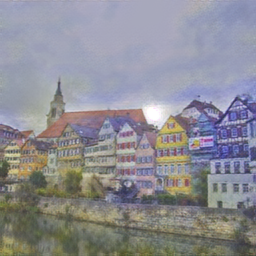

In [ ]:
# stylize_image(
#     model=model,
#     content_image_path="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/houses_content.jpg",
#     style_id=4,
#     output_dir="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/outputs",
#     device='cuda'
# )